In [50]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import block_diag
from matplotlib.lines import Line2D

module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = os.path.abspath(os.path.join('../../data'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from dynamics import Dynamics
from utils import get_form_initial_conditions
from centralized_newton import CentralizedNewton
from approxh_newton import ApproxHNewton
from tree_newton import TreeNewton
from gauss_newton import GaussNewton

try:
    from concurrent.futures import ProcessPoolExecutor
    use_several_cpus = True
except ImportError:
    print('No concurrent.futures.ProcessPoolExecutor available')
    use_several_cpus = False

In [51]:
# Position estimation error
def position_estimation_error(X_est, X_true):
    return np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).flatten(), np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).flatten(), np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).flatten(), np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).flatten()

In [52]:
# Simulation parameters
dt = 60.0  # Time step [s]
K = 395  # Duration [min]
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6 
n_p = 3  
n = N * n_x
o = 3 + 3 + 2 + 1 
o_tree = 3 + 1 + 1 + 1 
H = 15 # Window size [min]
invalid_rmse = 1e20 # [m]
grad_norm_order_mag = True
grad_norm_tol = 1e-6
max_iterations = 20
dyn = Dynamics()

In [53]:
# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R_deputies_tree = np.diag(np.concatenate([r_deputy_pos * np.ones(3)])) ** 2
R = block_diag(R_chief, R_deputies)
R_tree = block_diag(R_chief, R_deputies_tree)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P_0 = np.diag(np.concatenate([p_pos_initial * np.ones(3), p_vel_initial * np.ones(3)])) ** 2
P_0 = block_diag(P_0, P_0, P_0, P_0)

In [54]:
def plots(k, algorithm_class):
    iterations = np.arange(0, algorithm_class.iterations + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1
    axs[0].semilogy(iterations, 1 / H * np.array(algorithm_class.cost_values), '.-')
    axs[0].set_xlabel(r'$n$')
    axs[0].set_ylabel(r'$\frac{1}{H}J(x_n)$')
    axs[0].set_title('Normalized Cost Function') 
    axs[0].grid()

    # Plot 2
    axs[1].semilogy(iterations, 1 / H * np.array(algorithm_class.gradient_norm_values), '.-')
    axs[1].set_xlabel(r'$n$')
    axs[1].set_ylabel(r'$\frac{1}{H}||\nabla J(x_n)||_2$')
    axs[1].set_title('Normalized Gradient Norm')
    axs[1].grid()
    
    fig.suptitle(f'Solving MHE problem J(k) with k = {k}', fontsize=14)

    plt.tight_layout()
    plt.show()

In [55]:
# Seed for reproducibility
np.random.seed(42)

# Initial conditions for the state vector and true state vectors
X_initial = get_form_initial_conditions(formation)
with open(f"../../data/tudatpy_form{formation}.pkl", "rb") as file:
    X_true = pickle.load(file)[:, :, :K]

# Initial position estimation error
X_est = np.zeros_like(X_true)
X_est[:, :, 0] = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
for k in range(K - 1):
    X_est[:, :, k + 1] = dyn.f(dt, X_est[:, :, k])
position_estimation_error_1_initial, position_estimation_error_2_initial, position_estimation_error_3_initial, position_estimation_error_4_initial = position_estimation_error(X_est, X_true)

# Algorithms
centralized_newton = CentralizedNewton(H, K, o, R, grad_norm_order_mag, grad_norm_tol, max_iterations)
tree_newton = TreeNewton(H, K, o_tree, R_tree, grad_norm_order_mag, grad_norm_tol, max_iterations)
approxh_newton = ApproxHNewton(H, K, o, R, grad_norm_order_mag, grad_norm_tol, max_iterations)
gauss_newton = GaussNewton(H, K, o, R, grad_norm_order_mag, grad_norm_tol, max_iterations)

# Observations
Y = np.zeros((o, 1, K))
Y_tree = np.zeros((o_tree, 1, K))
for k in range(K):
    Y[:, :, k] = centralized_newton.h(X_true[:, :, k]) + np.random.multivariate_normal(np.zeros(o), R).reshape((o, 1))
    Y_tree[:, :, k] = tree_newton.h(X_true[:, :, k]) + np.random.multivariate_normal(np.zeros(o_tree), R_tree).reshape((o_tree, 1))
    
tree_newton.Y_original = Y
tree_newton.R_original = R

MHE problem:   0%|          | 0/381 [00:00<?, ?it/s]

[Gauss-Newton] Before applying the algorithm
Cost function: 44093575.688515075
Gradient norm: 201543914.4624147
Global estimation error: 314.5797683948257
Initial conditions estimation errors: 150.1199253316184 m, 105.5778492928544 m, 120.44789279753881 m, 225.32212569749123 m
Position estimation errors: 377.23236362284365 m, 86.12217884173707 m, 225.99285016895257 m, 283.70599585510917 m

[Gauss-Newton] Iteration 1
Cost function: 670968.6530450146 (-98.48%)
Gradient norm: 4078246.109294483 (-97.98%)
Global estimation error: 441.9430907764566 (40.49%)
Initial conditions estimation errors: 13.465876640169144 m, 315.72470771853256 m, 178.0826905611306 m, 252.44963892726625 m
Position estimation errors: 10.382616067924717 m, 130.04233580087072 m, 1264.2253622079782 m, 1404.0955484300778 m

[Gauss-Newton] Iteration 2
Cost function: 104402.69515679566 (-84.44%)
Gradient norm: 1424592.6059423366 (-65.07%)
Global estimation error: 129.1787837671107 (-70.77%)
Initial conditions estimation erro

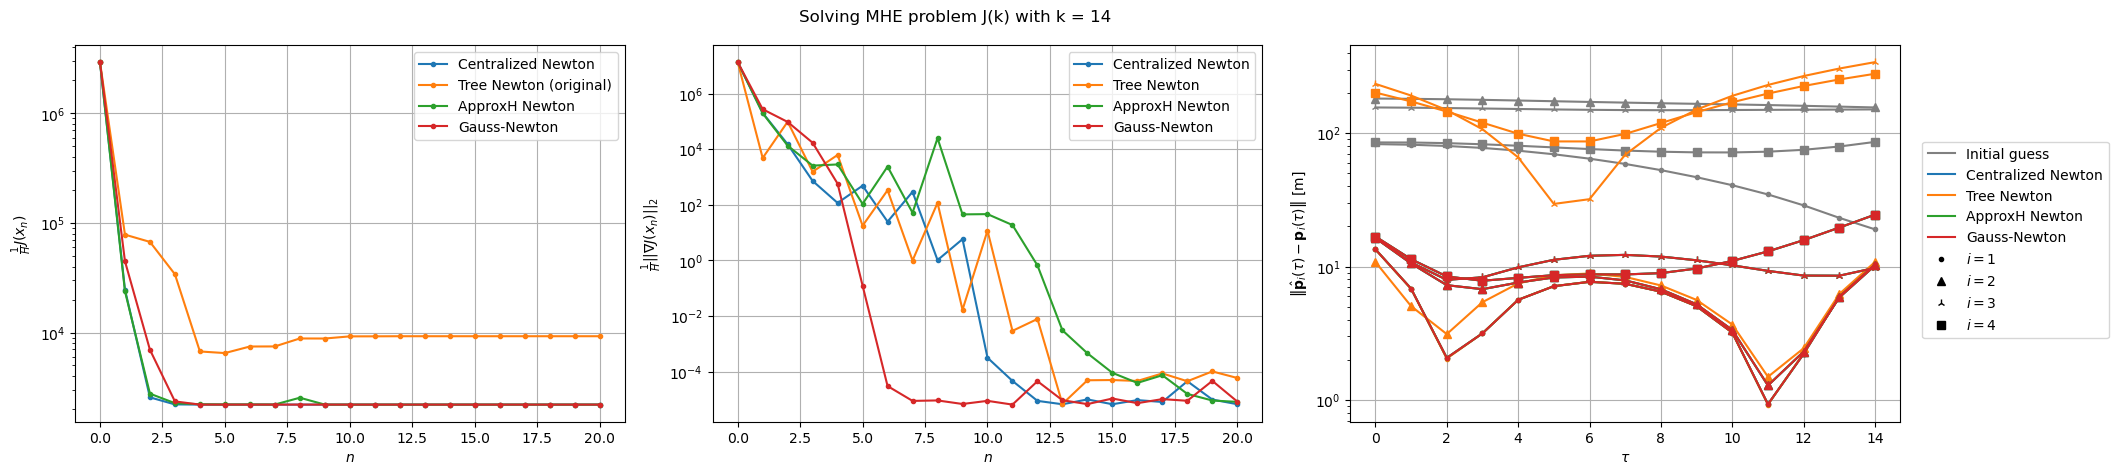

MHE problem:   0%|          | 1/381 [07:13<45:47:24, 433.80s/it]

[Gauss-Newton] Before applying the algorithm
Cost function: 35677.49222753051
Gradient norm: 1650239.0747743445
Global estimation error: 20.047960830345968
Initial conditions estimation errors: 6.827825157168189 m, 10.547439604099775 m, 10.731911191404693 m, 11.350530943271187 m
Position estimation errors: 15.398246141517461 m, 15.115825708292872 m, 12.347579856787487 m, 30.293616750017357 m

[Gauss-Newton] Iteration 1
Cost function: 27205.69514255213 (-23.75%)
Gradient norm: 2892.759742501566 (-99.82%)
Global estimation error: 25.628285159075595 (27.83%)
Initial conditions estimation errors: 12.20426454961792 m, 13.054177450573473 m, 13.47785534018254 m, 12.479704424469405 m
Position estimation errors: 9.821812317072748 m, 9.921636160617885 m, 26.163070892882317 m, 25.687729887766686 m

[Gauss-Newton] Iteration 2
Cost function: 27205.349178751152 (-0.00%)
Gradient norm: 0.41573009608548345 (-99.99%)
Global estimation error: 25.58922606022909 (-0.15%)
Initial conditions estimation erro

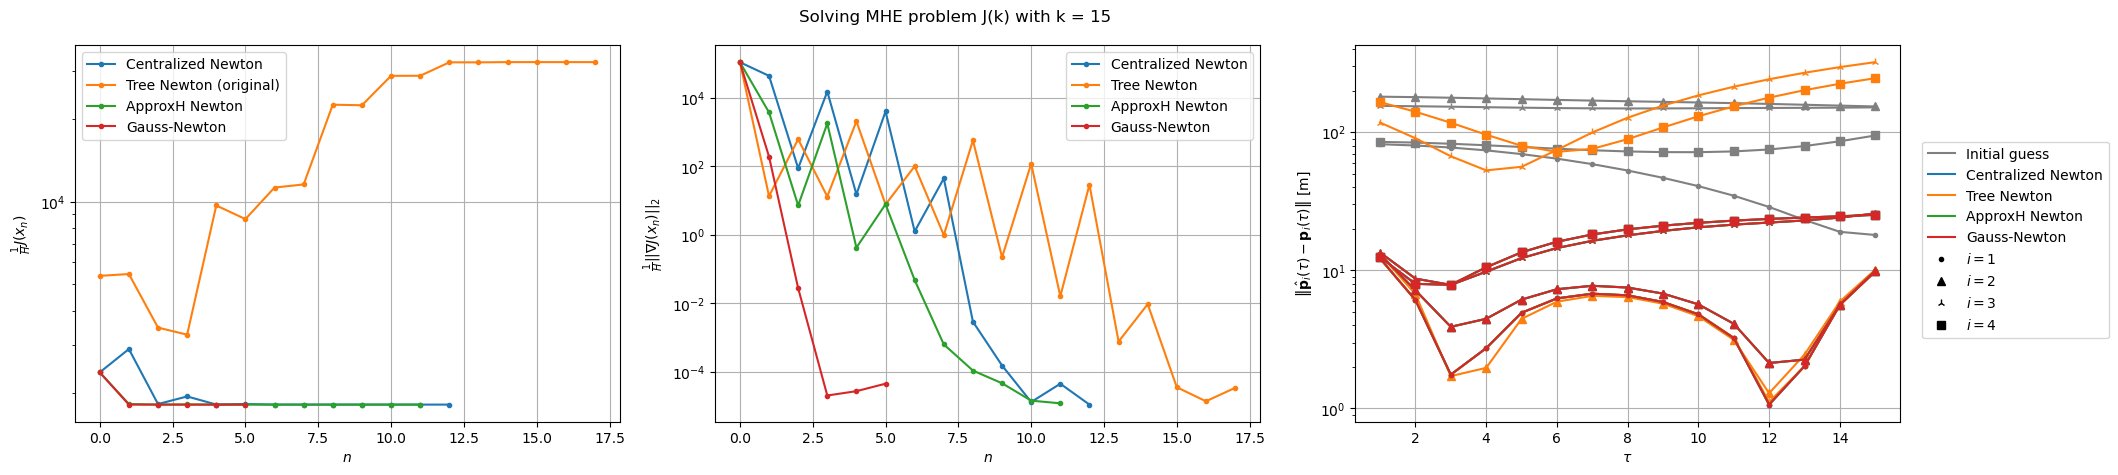

MHE problem:   1%|          | 2/381 [11:50<35:57:24, 341.54s/it]

[Gauss-Newton] Before applying the algorithm
Cost function: 30594.782287846698
Gradient norm: 1554184.1102298584
Global estimation error: 15.10456870191128
Initial conditions estimation errors: 6.097505824133406 m, 7.168105201893265 m, 8.709325901201908 m, 7.981020132313794 m
Position estimation errors: 14.524721252648902 m, 14.807030701412078 m, 28.13011505117911 m, 26.024569703486804 m

[Gauss-Newton] Iteration 1
Cost function: 23159.31322719778 (-24.30%)
Gradient norm: 5033.207399873091 (-99.68%)
Global estimation error: 33.57205210675386 (122.26%)
Initial conditions estimation errors: 11.06446038726346 m, 17.537172681478093 m, 20.395300057710628 m, 16.765243886032977 m
Position estimation errors: 9.246386816016585 m, 9.4464188722113 m, 77.72965511834028 m, 77.95346242883635 m

[Gauss-Newton] Iteration 2
Cost function: 23158.370582485906 (-0.00%)
Gradient norm: 0.11588363538520863 (-100.00%)
Global estimation error: 33.31789724285566 (-0.76%)
Initial conditions estimation errors: 11

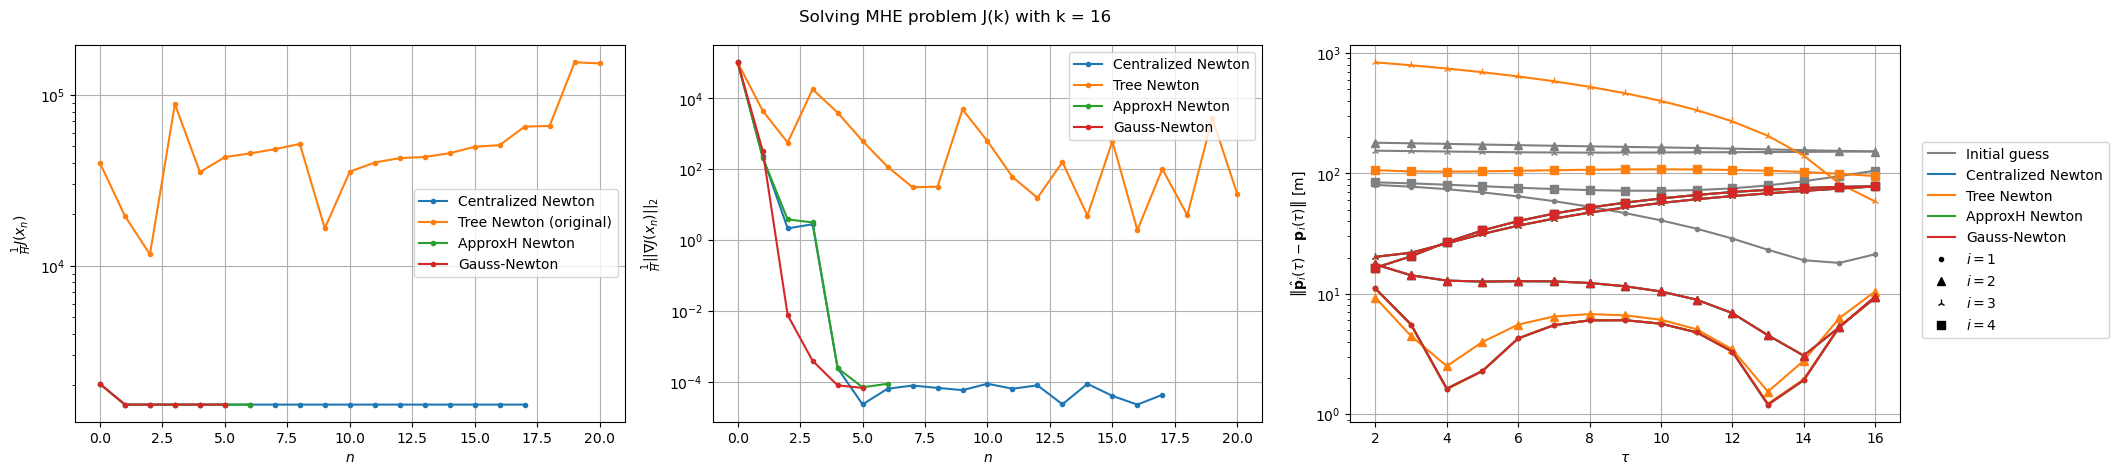

MHE problem:   1%|          | 3/381 [16:43<33:30:10, 319.07s/it]

[Gauss-Newton] Before applying the algorithm
Cost function: 26416.34534993668
Gradient norm: 1382467.3105561729
Global estimation error: 33.66991963887543
Initial conditions estimation errors: 5.551804189043901 m, 14.236485586424907 m, 21.924977285756643 m, 20.479498738182997 m
Position estimation errors: 13.617644482818058 m, 14.371595094569484 m, 81.00298949572479 m, 78.03272289088711 m

[Gauss-Newton] Iteration 1
Cost function: 20317.189303493546 (-23.09%)
Gradient norm: 3365.259928142266 (-99.76%)
Global estimation error: 26.151417713209796 (-22.33%)
Initial conditions estimation errors: 10.015083555745543 m, 13.162272794472697 m, 17.294962841399805 m, 10.544921717620195 m
Position estimation errors: 8.83127803739126 m, 10.380399174131735 m, 35.83868709426754 m, 32.3576216697242 m

[Gauss-Newton] Iteration 2
Cost function: 20316.795314741084 (-0.00%)
Gradient norm: 0.13009364276819507 (-100.00%)
Global estimation error: 26.339701111071154 (0.72%)
Initial conditions estimation error

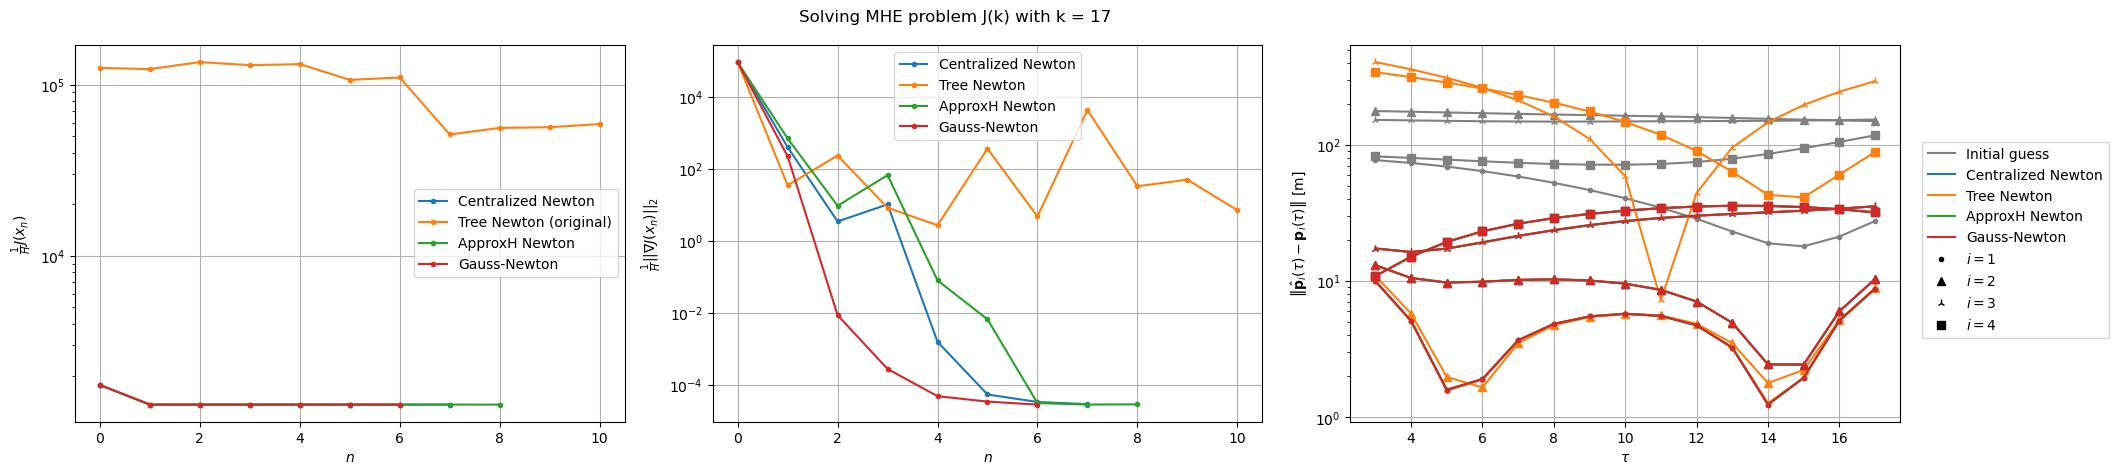

MHE problem:   1%|          | 4/381 [19:48<27:54:09, 266.44s/it]

[Gauss-Newton] Before applying the algorithm
Cost function: 23696.577740953
Gradient norm: 1275008.6423480636
Global estimation error: 25.21922281558152
Initial conditions estimation errors: 5.114405006811019 m, 10.5627392047935 m, 16.39241271774548 m, 15.150744225599949 m
Position estimation errors: 12.895821449218845 m, 15.193404945022081 m, 37.329654503078174 m, 29.83308336706969 m

[Gauss-Newton] Iteration 1
Cost function: 18413.701832362683 (-22.29%)
Gradient norm: 484.34343395213625 (-99.96%)
Global estimation error: 30.815764199288015 (22.19%)
Initial conditions estimation errors: 9.229290726283097 m, 9.470896903778254 m, 20.81358772619756 m, 18.47971575163551 m
Position estimation errors: 8.437897677999517 m, 10.283841566777635 m, 21.477429403572867 m, 10.519745488521597 m

[Gauss-Newton] Iteration 2
Cost function: 18413.687819388357 (-0.00%)
Gradient norm: 3.2715300948333734 (-99.32%)
Global estimation error: 31.84377497408092 (3.34%)
Initial conditions estimation errors: 9.22

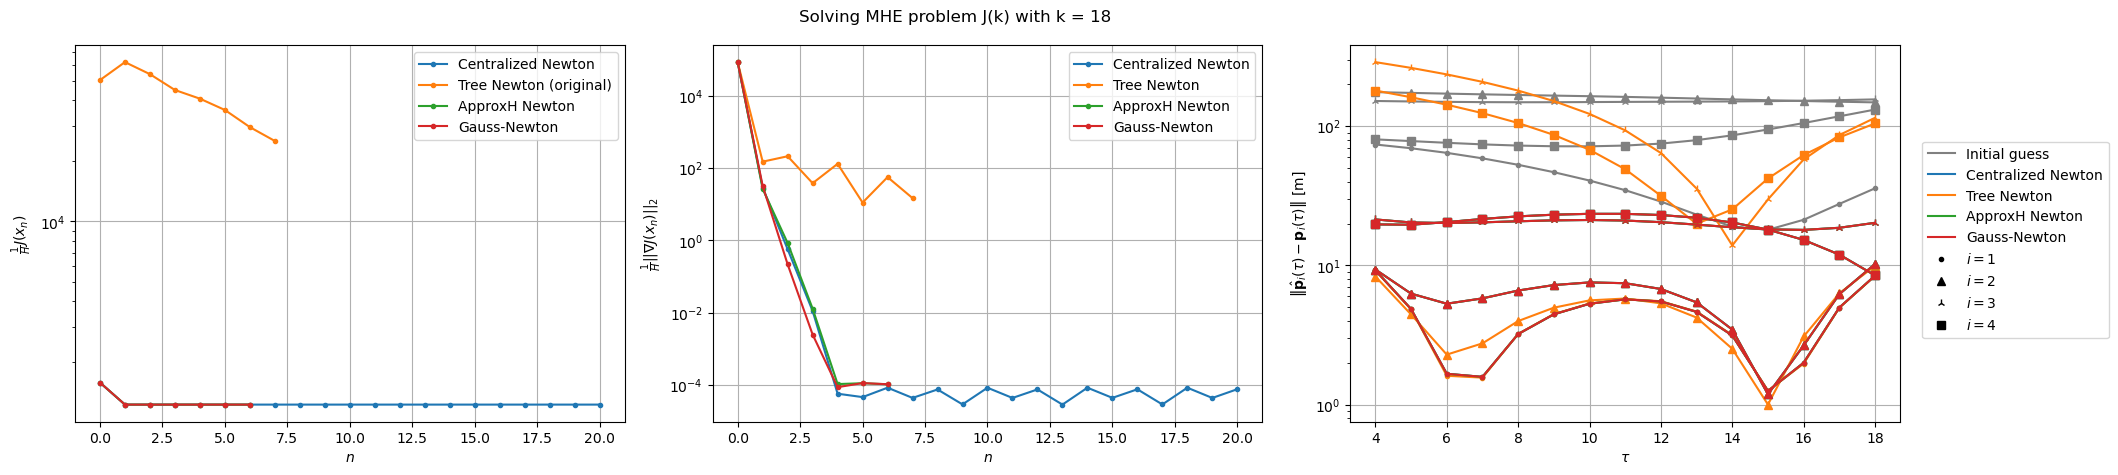

MHE problem:   1%|▏         | 5/381 [23:10<25:24:10, 243.22s/it]

[Gauss-Newton] Before applying the algorithm
Cost function: 21654.09151832453
Gradient norm: 1147739.2855620657
Global estimation error: 29.351048512352115
Initial conditions estimation errors: 4.861305455485569 m, 6.2723818818152495 m, 20.35084267841726 m, 19.604468686638242 m
Position estimation errors: 12.24321687821039 m, 14.626069679655595 m, 22.822545596811164 m, 5.636361098757169 m

[Gauss-Newton] Iteration 1
Cost function: 17174.90148836992 (-20.69%)
Gradient norm: 104.36464025113118 (-99.99%)
Global estimation error: 29.051686020737446 (-1.02%)
Initial conditions estimation errors: 8.620431517363606 m, 8.826686300756585 m, 19.95343974234226 m, 17.13522534581993 m
Position estimation errors: 8.153775796588183 m, 10.969914758361375 m, 25.587569828493546 m, 16.492083765746358 m

[Gauss-Newton] Iteration 2
Cost function: 17174.900887967116 (-0.00%)
Gradient norm: 0.13857943131001943 (-99.87%)
Global estimation error: 29.472488646380853 (1.45%)
Initial conditions estimation errors:

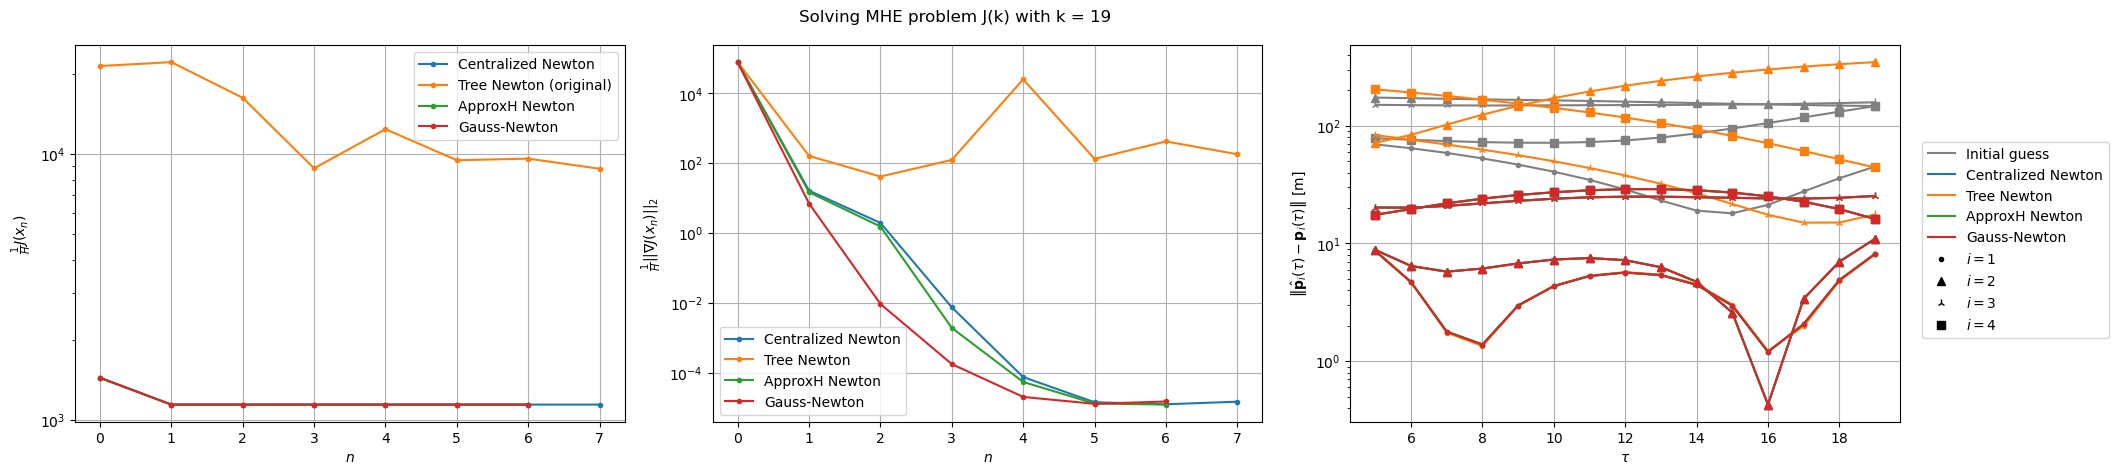

MHE problem:   2%|▏         | 6/381 [25:48<22:18:50, 214.22s/it]

[Gauss-Newton] Before applying the algorithm
Cost function: 20533.069628843634
Gradient norm: 1058959.2772968556
Global estimation error: 29.2111738457584
Initial conditions estimation errors: 4.693073282557014 m, 6.439715072023949 m, 20.140592708759645 m, 19.599497885197714 m
Position estimation errors: 11.778901949218008 m, 15.26684788803562 m, 26.926693124723155 m, 12.298702807716637 m

[Gauss-Newton] Iteration 1
Cost function: 16503.425234022994 (-19.63%)
Gradient norm: 400.7377403135316 (-99.96%)
Global estimation error: 25.703874249711344 (-12.01%)
Initial conditions estimation errors: 8.22233929092603 m, 8.909161897573469 m, 16.1179899780585 m, 15.934163174606434 m
Position estimation errors: 7.91566157280205 m, 11.641301998167496 m, 24.794133250052692 m, 15.238144593445709 m

[Gauss-Newton] Iteration 2
Cost function: 16503.279232385274 (-0.00%)
Gradient norm: 6.857617984692014 (-98.29%)
Global estimation error: 22.803657493968736 (-11.28%)
Initial conditions estimation errors: 

Process ForkProcess-122:
Process ForkProcess-123:
Process ForkProcess-118:
Traceback (most recent call last):
Process ForkProcess-119:
Process ForkProcess-117:
Process ForkProcess-116:
Traceback (most recent call last):
Process ForkProcess-121:
Process ForkProcess-124:
Traceback (most recent call last):
Process ForkProcess-120:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/joaomarafuzgaspar/.conda/envs/spacesim-toolkit/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/joaomarafuzgaspar/.conda/envs/spacesim-toolkit/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/joaomarafuzgaspar/.conda/envs/spacesim-toolkit/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/joaomarafuzgas

In [ ]:
# Initialize storage arrays for state estimates
X_est_centralized_newton_history = np.zeros((n, 1, K))  # Centralized Newton
X_est_tree_newton_history = np.zeros((n, 1, K))  # Tree Newton
X_est_approxh_newton_history = np.zeros((n, 1, K))  # ApproxH Newton
X_est_gauss_newton_history = np.zeros((n, 1, K))  # Gauss-Newton

def solve_MHE_problem(algorithm_name, algorithm, k, dt, Y, x_init, x_true_initial, x_true_end):
    x_init, x_est = algorithm.solve_MHE_problem(k, dt, Y, x_init, x_true_initial, x_true_end)
    return algorithm_name, x_init, x_est, algorithm.cost_values.copy(), algorithm.gradient_norm_values.copy()

# ================= MAIN EXECUTION =================

# Cold-start
x_init = X_initial + np.random.multivariate_normal(np.zeros(n), P_0).reshape((n, 1))
x_init_centralized_newton = x_init
x_init_tree_newton = x_init
x_init_approxh_newton = x_init
x_init_gauss_newton = x_init

for k in tqdm(range(H - 1, K), desc="MHE problem", leave=False):
    with ProcessPoolExecutor(max_workers=12) as executor:
        # Run each algorithm in parallel
        future_to_algorithm = {
            executor.submit(solve_MHE_problem, "Centralized Newton", centralized_newton, k, dt, Y, x_init_centralized_newton, X_true[:, :, k - H + 1],  X_true[:, :, k]): "Centralized Newton",
            executor.submit(solve_MHE_problem, "Tree Newton", tree_newton, k, dt, Y_tree, x_init_tree_newton, X_true[:, :, k - H + 1],  X_true[:, :, k]): "Tree Newton",
            executor.submit(solve_MHE_problem, "ApproxH Newton", approxh_newton, k, dt, Y, x_init_approxh_newton, X_true[:, :, k - H + 1],  X_true[:, :, k]): "ApproxH Newton",
            executor.submit(solve_MHE_problem, "Gauss-Newton", gauss_newton, k, dt, Y, x_init_gauss_newton, X_true[:, :, k - H + 1],  X_true[:, :, k]): "Gauss-Newton",
        }

        # Retrieve results in the main process
        results = {future.result()[0]: future.result()[1:] for future in future_to_algorithm}

    # Extract updated estimates
    x_init_centralized_newton, x_est_centralized_newton, cost_centralized_newton, grad_centralized_newton = results["Centralized Newton"]
    x_init_tree_newton, x_est_tree_newton, cost_tree_newton, grad_tree_newton = results["Tree Newton"]
    x_init_approxh_newton, x_est_approxh_newton, cost_approxh_newton, grad_approxh_newton = results["ApproxH Newton"]
    x_init_gauss_newton, x_est_gauss_newton, cost_gauss_newton, grad_gauss_newton = results["Gauss-Newton"]
        
    # Plot results **in the main process**
    fig, axs = plt.subplots(1, 3, figsize=(3 * 6.4, 4.8))

    # Cost function values
    axs[0].plot(1 / H * np.array(cost_centralized_newton), '.-', label='Centralized Newton')
    axs[0].plot(1 / H * np.array(cost_tree_newton), '.-', label='Tree Newton (original)')
    axs[0].plot(1 / H * np.array(cost_approxh_newton), '.-', label='ApproxH Newton')
    axs[0].plot(1 / H * np.array(cost_gauss_newton), '.-', label='Gauss-Newton')
    axs[0].set_xlabel(r'$n$')
    axs[0].set_ylabel(r'$\frac{1}{H}J(x_n)$')
    axs[0].set_yscale('log')
    axs[0].grid(True)
    axs[0].legend()

    # Gradient norm values
    axs[1].plot(1 / H * np.array(grad_centralized_newton), '.-', label='Centralized Newton')
    axs[1].plot(1 / H * np.array(grad_tree_newton), '.-', label='Tree Newton')
    axs[1].plot(1 / H * np.array(grad_approxh_newton), '.-', label='ApproxH Newton')
    axs[1].plot(1 / H * np.array(grad_gauss_newton), '.-', label='Gauss-Newton')
    axs[1].set_xlabel(r'$n$')
    axs[1].set_ylabel(r'$\frac{1}{H}||\nabla J(x_n)||_2$')
    axs[1].set_yscale('log')
    axs[1].grid(True)
    axs[1].legend()

    # Initialize storage for current estimates
    X_est_centralized_newton_current = np.zeros((24, 1, H))
    X_est_tree_newton_current = np.zeros((24, 1, H))
    X_est_approxh_newton_current = np.zeros((24, 1, H))
    X_est_gauss_newton_current = np.zeros((24, 1, H))
    
    # Simulate forward propagation over the window
    X_est_centralized_newton_current[:, :, 0] = x_init_centralized_newton
    X_est_tree_newton_current[:, :, 0] = x_init_tree_newton
    X_est_approxh_newton_current[:, :, 0] = x_init_approxh_newton
    X_est_gauss_newton_current[:, :, 0] = x_init_gauss_newton
    for tau in range(H - 1):
        X_est_centralized_newton_current[:, :, tau + 1] = dyn.f(dt, X_est_centralized_newton_current[:, :, tau])
        X_est_tree_newton_current[:, :, tau + 1] = dyn.f(dt, X_est_tree_newton_current[:, :, tau])
        X_est_approxh_newton_current[:, :, tau + 1] = dyn.f(dt, X_est_approxh_newton_current[:, :, tau])
        X_est_gauss_newton_current[:, :, tau + 1] = dyn.f(dt, X_est_gauss_newton_current[:, :, tau])
    
    # Compute position estimation errors
    dev_chief_centralized_newton_current, dev_deputy1_centralized_newton_current, dev_deputy2_centralized_newton_current, dev_deputy3_centralized_newton_current = position_estimation_error(X_est_centralized_newton_current, X_true[:, :, k - H + 1 : k + 1])
    dev_chief_tree_newton_current, dev_deputy1_tree_newton_current, dev_deputy2_tree_newton_current, dev_deputy3_tree_newton_current = position_estimation_error(X_est_tree_newton_current, X_true[:, :, k - H + 1 : k + 1])
    dev_chief_approxh_newton_current, dev_deputy1_approxh_newton_current, dev_deputy2_approxh_newton_current, dev_deputy3_approxh_newton_current = position_estimation_error(X_est_approxh_newton_current, X_true[:, :, k - H + 1 : k + 1])
    dev_chief_gauss_newton_current, dev_deputy1_gauss_newton_current, dev_deputy2_gauss_newton_current, dev_deputy3_gauss_newton_current = position_estimation_error(X_est_gauss_newton_current, X_true[:, :, k - H + 1 : k + 1])
    
    # Define colors for algorithms
    algorithm_colors = {
        'Initial Guess': 'grey',
        'Centralized Newton': 'C0',
        'Tree Newton': 'C1',
        'ApproxH Newton': 'C2',
        'Gauss-Newton': 'C3'
    }
    
    # Define markers for different agents (i = 1, ..., 4)
    markers = ['.', '^', '2', 's', 'P']
    
    # Plot position estimation errors
    for i, dev_initial in enumerate([position_estimation_error_1_initial, position_estimation_error_2_initial, position_estimation_error_3_initial, position_estimation_error_4_initial]):
        axs[2].plot(np.arange(k - H + 1, k + 1), dev_initial[k - H + 1 : k + 1], linestyle='-', color=algorithm_colors['Initial Guess'], marker=markers[i])
    for i, dev_unkkt in enumerate([dev_chief_centralized_newton_current, dev_deputy1_centralized_newton_current, dev_deputy2_centralized_newton_current, dev_deputy3_centralized_newton_current]):
        axs[2].plot(np.arange(k - H + 1, k + 1), dev_unkkt, linestyle='-', color=algorithm_colors['Centralized Newton'], marker=markers[i])
    for i, dev_tree in enumerate([dev_chief_tree_newton_current, dev_deputy1_tree_newton_current, dev_deputy2_tree_newton_current, dev_deputy3_tree_newton_current]):
        axs[2].plot(np.arange(k - H + 1, k + 1), dev_tree, linestyle='-', color=algorithm_colors['Tree Newton'], marker=markers[i])
    for i, dev_approxh in enumerate([dev_chief_approxh_newton_current, dev_deputy1_approxh_newton_current, dev_deputy2_approxh_newton_current, dev_deputy3_approxh_newton_current]):
        axs[2].plot(np.arange(k - H + 1, k + 1), dev_approxh, linestyle='-', color=algorithm_colors['ApproxH Newton'], marker=markers[i])
    for i, dev_mm in enumerate([dev_chief_gauss_newton_current, dev_deputy1_gauss_newton_current, dev_deputy2_gauss_newton_current, dev_deputy3_gauss_newton_current]):
        axs[2].plot(np.arange(k - H + 1, k + 1), dev_mm, linestyle='-', color=algorithm_colors['Gauss-Newton'], marker=markers[i])
    
    # Set axis labels and scale
    axs[2].set_xlabel(r'$\tau$')
    axs[2].set_ylabel(r'$\left\|\hat{\mathbf{p}}_i(\tau) - \mathbf{p}_i(\tau)\right\|$ [m]')
    axs[2].set_yscale('log')
    axs[2].grid(True)
    
    # Create legend (Colors for Algorithms, Markers for Agents)
    legend_elements = [
        Line2D([0], [0], linestyle='-', color=algorithm_colors['Initial Guess'], label='Initial guess'),
        Line2D([0], [0], linestyle='-', color=algorithm_colors['Centralized Newton'], label='Centralized Newton'),
        Line2D([0], [0], linestyle='-', color=algorithm_colors['Tree Newton'], label='Tree Newton'),
        Line2D([0], [0], linestyle='-', color=algorithm_colors['ApproxH Newton'], label='ApproxH Newton'),
        Line2D([0], [0], linestyle='-', color=algorithm_colors['Gauss-Newton'], label='Gauss-Newton'),
        Line2D([0], [0], linestyle='', marker='.', color='black', label='$i = 1$'),
        Line2D([0], [0], linestyle='', marker='^', color='black', label='$i = 2$'),
        Line2D([0], [0], linestyle='', marker='2', color='black', label='$i = 3$'),
        Line2D([0], [0], linestyle='', marker='s', color='black', label='$i = 4$')
    ]
    fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

    fig.suptitle(f'Solving MHE problem J(k) with k = {k}')
    plt.tight_layout() 
    plt.show()

    # Update state estimates
    x_init_centralized_newton = dyn.f(dt, x_init_centralized_newton)
    x_init_tree_newton = dyn.f(dt, x_init_tree_newton)
    x_init_approxh_newton = dyn.f(dt, x_init_approxh_newton)
    x_init_gauss_newton = dyn.f(dt, x_init_gauss_newton)
    x_init = dyn.f(dt, x_init)